In [1]:
import pandas as pd

# Load the dataset

data_path = 'path_loss_data.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df.head()


,Frequency,Distance,Transmitter Height,Receiver Height,Antenna Gain,Environment,Obstacle Distance,Path Characteristics,Weather Conditions,Shadowing Effects,Frequency Bandwidth,Path Loss
0,2.171407e+09,368.853581,42.029355,2.287991,14.207688,rural,46.066300,NLOS,rainy,-3.337696,7.485061e+07,323.535247
1,2.557608e+09,145.408870,27.104702,2.348117,19.149884,urban,4.217460,LOS,rainy,3.208956,3.263869e+07,302.101930
2,3.581872e+09,60.766213,35.515670,3.815246,17.524410,urban,51.372558,LOS,rainy,-2.924875,5.825732e+07,306.735772
3,1.868878e+09,206.794088,42.936580,5.319497,16.790897,urban,59.819078,LOS,rainy,-1.941350,6.733324e+07,319.448295
4,1.119490e+09,186.455720,40.528642,9.723401,9.560728,suburban,54.458540,NLOS,clear,-2.907063,7.114606e+07,344.803098


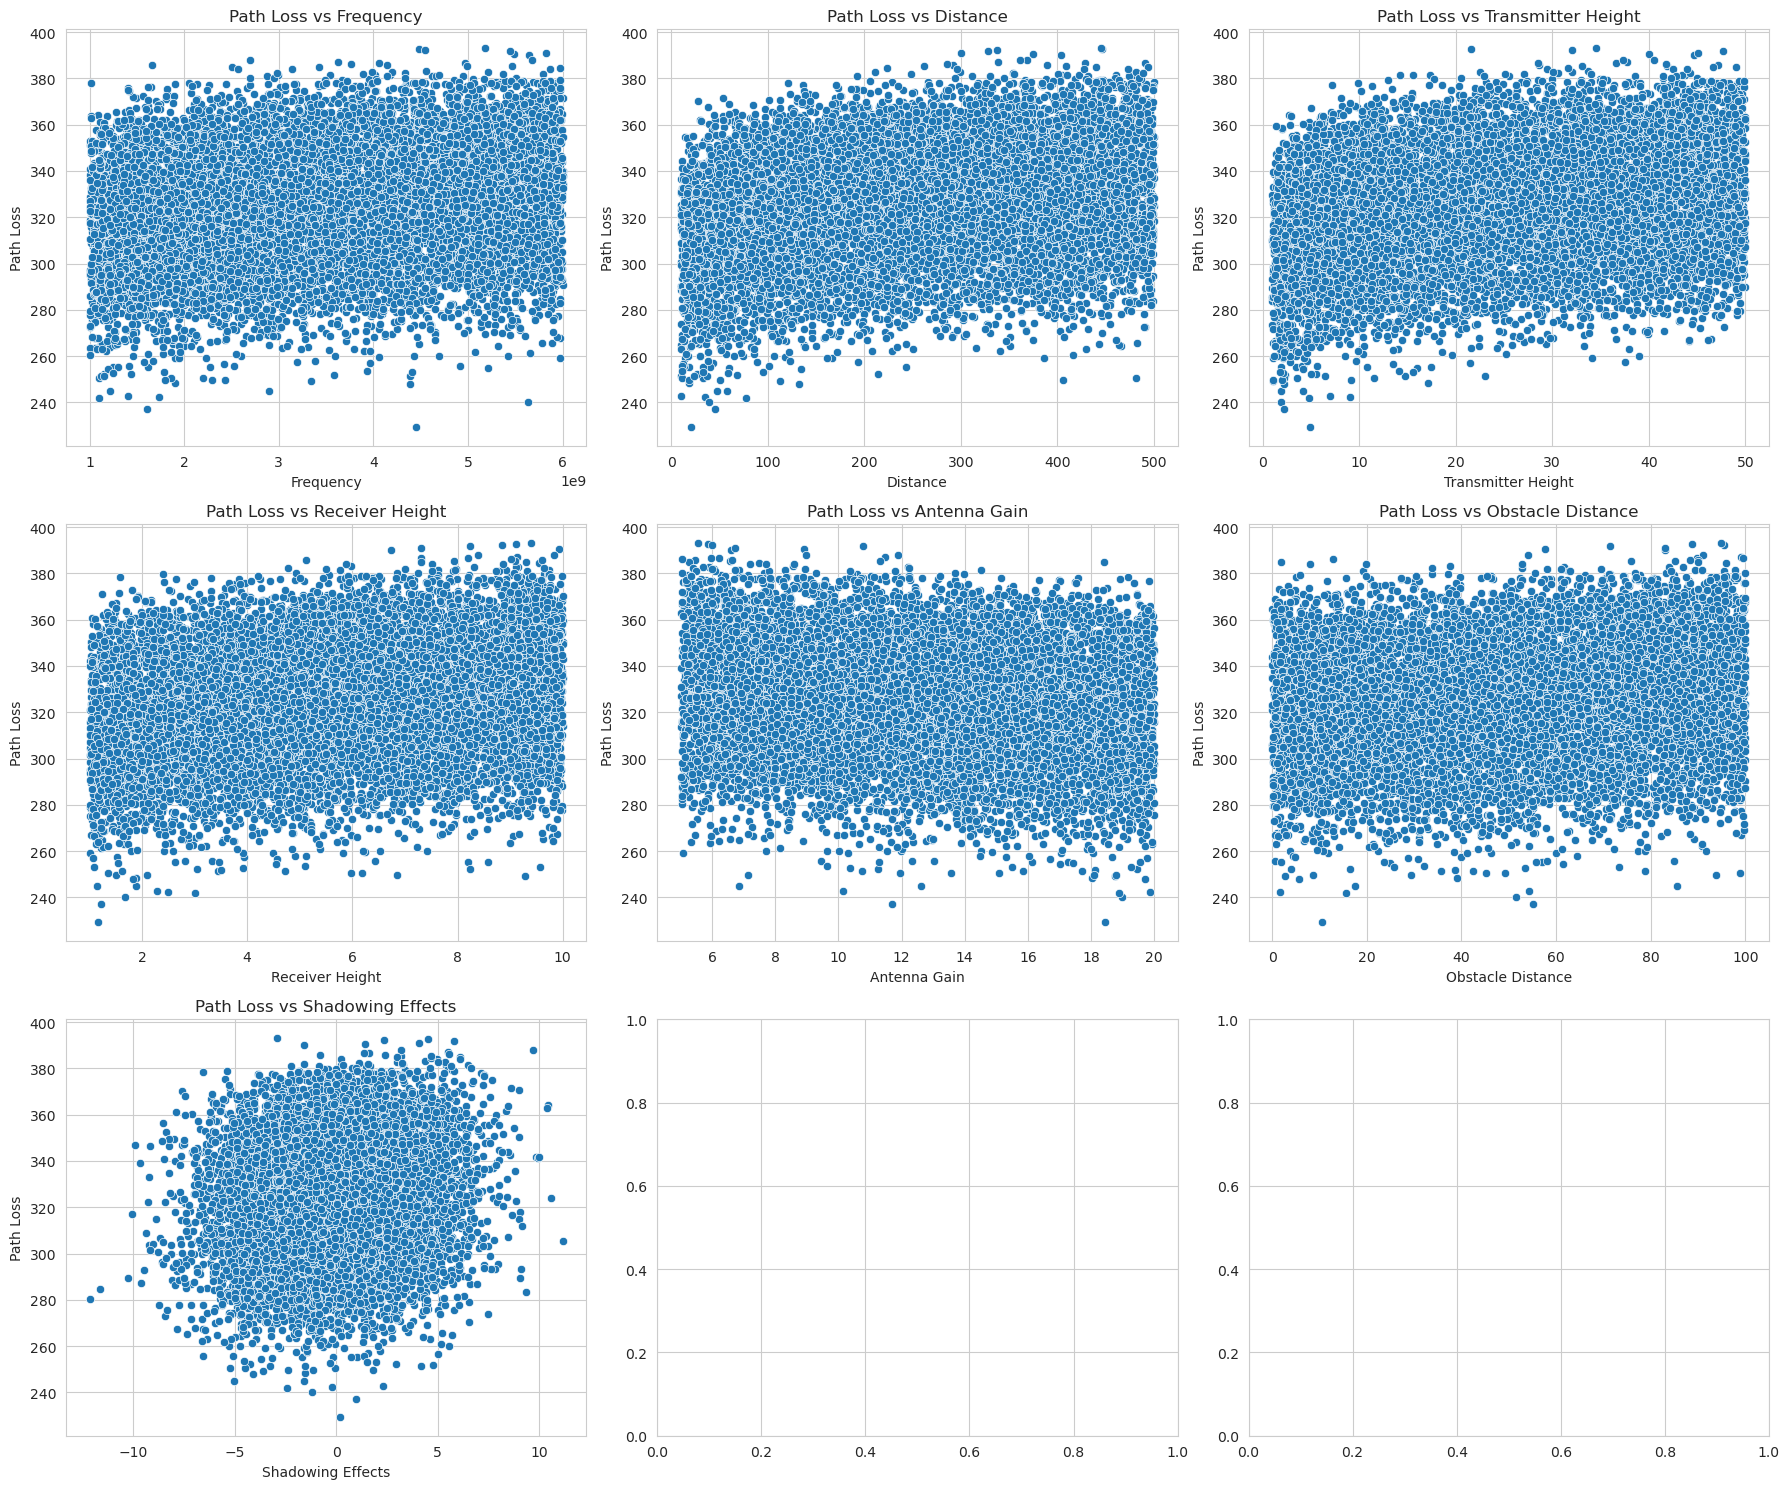

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Prepare a figure to contain multiple subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

# List of numerical variables to plot against Path Loss
numerical_vars = ['Frequency', 'Distance', 'Transmitter Height', 'Receiver Height', 'Antenna Gain', 'Obstacle Distance', 'Shadowing Effects']

for ax, var in zip(axs.flat, numerical_vars):
    sns.scatterplot(data=df, x=var, y='Path Loss', ax=ax)
    ax.set_title(f'Path Loss vs {var}')

# Adjust layout
plt.tight_layout()

plt.show()



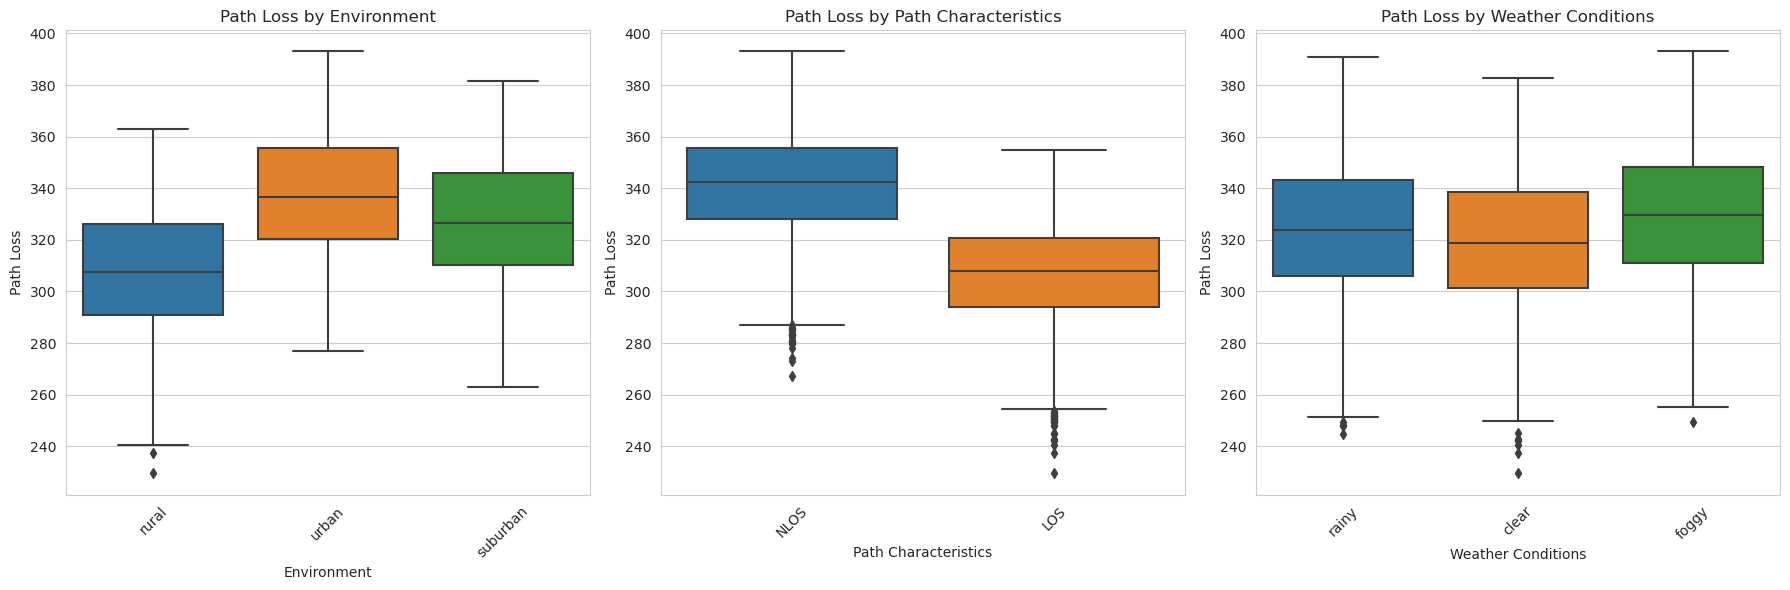

In [3]:
# Next, we will create box plots for categorical variables
categorical_vars = ['Environment', 'Path Characteristics', 'Weather Conditions']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for ax, var in zip(axs.flat, categorical_vars):
    sns.boxplot(x=var, y='Path Loss', data=df, ax=ax)
    ax.set_title(f'Path Loss by {var}')
    plt.setp(ax.get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()

plt.show()


/home/lukmanaj/miniconda3/envs/arewads/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


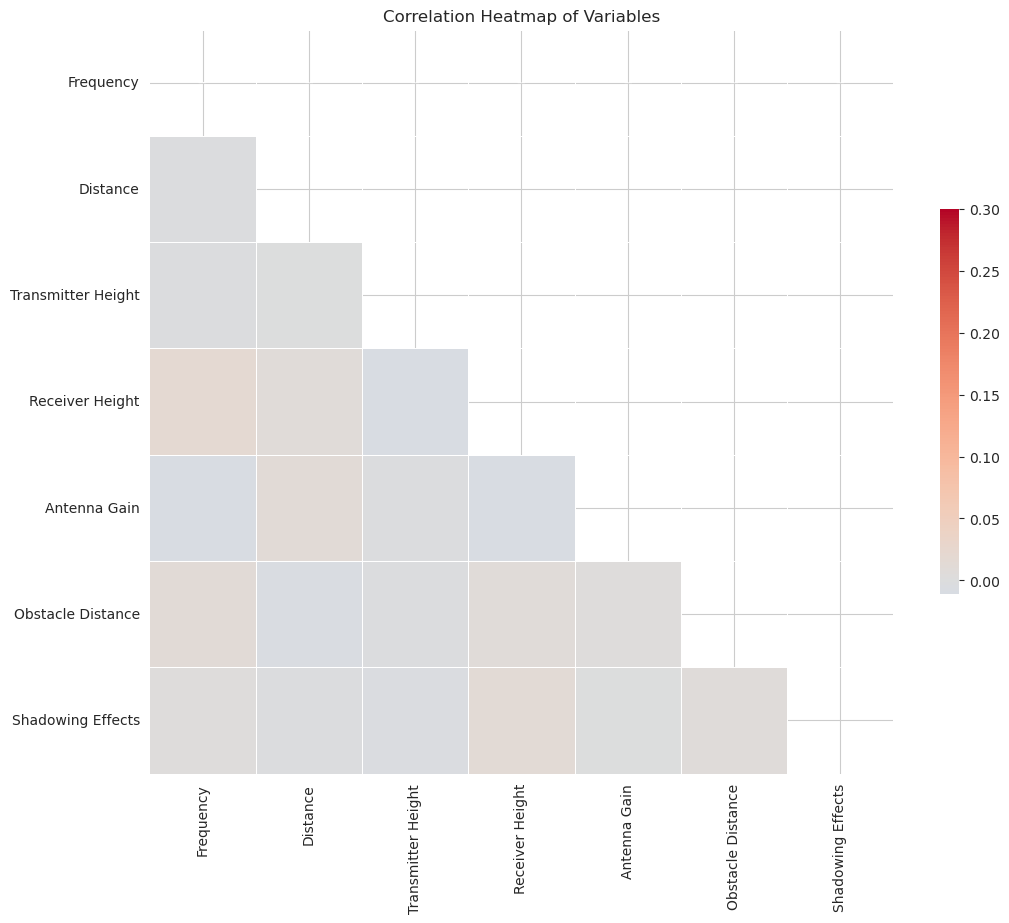

In [10]:
# To understand the correlation between different numerical variables, including path loss,
# we'll use a correlation matrix and visualize it using a heatmap.
import numpy as np
# Compute the correlation matrix
corr_matrix = df[numerical_vars].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Add title
plt.title('Correlation Heatmap of Variables')

plt.show()


In [11]:
corr_matrix

,Frequency,Distance,Transmitter Height,Receiver Height,Antenna Gain,Obstacle Distance,Shadowing Effects
Frequency,1.000000,-0.001992,-0.003664,0.017811,-0.009278,0.010935,0.003037
Distance,-0.001992,1.000000,-0.001034,0.009464,0.011064,-0.008213,-0.003340
Transmitter Height,-0.003664,-0.001034,1.000000,-0.011063,-0.001857,-0.002600,-0.005318
Receiver Height,0.017811,0.009464,-0.011063,1.000000,-0.010594,0.008907,0.013597
Antenna Gain,-0.009278,0.011064,-0.001857,-0.010594,1.000000,0.004719,0.000999
Obstacle Distance,0.010935,-0.008213,-0.002600,0.008907,0.004719,1.000000,0.007037
Shadowing Effects,0.003037,-0.003340,-0.005318,0.013597,0.000999,0.007037,1.000000


# Preprocessing For PyTorch

The code below includes preprocessing steps for PyTorch models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Selecting features and target
X = df.drop('Path Loss', axis=1)
y = df['Path Loss']

# Defining the preprocessing for categorical and numerical features
categorical_features = ['Environment', 'Path Characteristics', 'Weather Conditions']
numerical_features = X.columns.difference(categorical_features)

# Creating the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Check the shape of the transformed features
X_train_transformed.shape, X_test_transformed.shape


((8000, 16), (2000, 16))

In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [6]:
len(train_loader),len(test_loader)

(125, 32)